In [15]:
import Pkg
Pkg.activate("../Tasks2D")

  Activating project at `~/Developer/tasks2D/Tasks2D`


In [16]:
using Revise      # For development; makes it so modifications
                  # to imported modules are immediately reflected in this Julia session

import LineWorlds # Local module with code for 2D maps where
                  # the primitive objects are line segments.
const L = LineWorlds
const Geo = L.Geometry;

## Environment with rooms

In this model we have a very simple symbolic representation of rooms (which we assume are rectangles, and store as a named tuple `(; bl = (leftmost_x, bottommost_y), wh = (width, height))`).

In [17]:
### Load the following simple functions for dealing with rooms and positions:
# `rect_to_segs((bottom, left), (width, height))`, `target_object_placed(room_assignment_dict)`,
# `get_target_room(room_assignment_dict)`, `in_room(position, room)`, `room_containing(position, params)`,
# `room_center(room)`, `taxi_dist_to_room_center(position, room)`, `nearest_unexplored_room(position, params, room_assignment_dict)`,
# `object_pos(room_assignment_dict, target_relative_to_pos)`, `segments_for_object_in(target_room, target_pose_relative_to_room)`
includet("RoomSearch/room_utils.jl")

In [18]:
# Load function to construct a "hotel" map with a given number
# of identical rooms.
includet("RoomSearch/hotel_env.jl")

# Construct a hotel environment with 4 rooms.
(walls, bounding_box) = construct_hotel_env(4);

# Get the rooms in the hotel; each is represented as a rectangle
rooms = get_hotel_rooms(4);

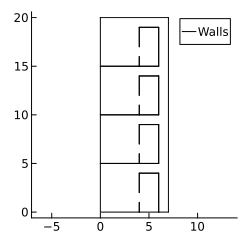

In [19]:
using Plots
plot(size=(250, 250), aspect_ratio=:equal, grid=false)
plot!(walls, c=:black, label="Walls")

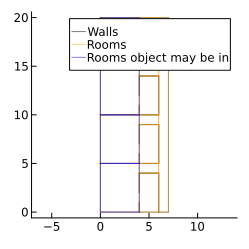

In [88]:
# Convert the room rectangles to line segments.
room_segs = vcat([rect_to_segs(room.bl, room.wh) for room in rooms]...)

# Also, get the rectangles for the 4 "main" hotel rooms.
# Later, we'll tell the agent that the object is in one of these "main" rooms
# (but not the hallways and closets).
main_rooms = _rooms(4)
sq_room_segs = vcat([rect_to_segs(room.bl, room.wh) for room in main_rooms]...);

# Visualize:
using Plots
plot(size=(250, 250), aspect_ratio=:equal, grid=false)
plot!(walls, c=:black, linealpha=0.5, label="Walls")
plot!(room_segs, c=:orange, linealpha=0.5, label="Rooms")
plot!(sq_room_segs, c=:blue, linealpha=0.5, label="Rooms object may be in")

## Ground truth world model

The POMDP state at each time t is a pair (agent position, target room).  The target room is the room in which the goal ("target") object is located.

The target room is sampled at t=0 and never changes subsequently. The position changes at each time step.

We assume that the agent knows where in the target room the target object will be.  (E.g. it was told, "get my keys from my room; they're on my bedside table".)  So the only uncertainty it needs to disambiguate regarding the object position is _which_ room it is in, not where in the room it is.  (This is a simplification I made to simplify the problem on my first pass--but I haven't gotten to removing the simplification yet.)

In [21]:
using Gen

In [22]:
### Initial state distribution ###

@dist labeled_categorical(labels, probs) = labels[categorical(probs)]

mvuniform = L.ProductDistribution(uniform);
@gen function world_initial_model(params)

    # Agent pos
    mins, maxs = params.bounding_box
    pos ~ mvuniform(mins, maxs)

    # Which room is the target object in?
    target_room ~ labeled_categorical(params.viable_rooms, [1/length(params.viable_rooms) for _ in params.viable_rooms])
    
    # POMDP state: agent position; which room the target object is in
    return (; pos, target_room)
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any], false, Union{Nothing, Some{Any}}[nothing], var"##world_initial_model#321", Bool[0], false)

In [23]:
includet("KidnappedRobot/motion_model_utils.jl")

@gen function motion_model(prev_pos, action, params)
    # Move the agent up/down/left/right by params.step.Δ units.
    np = det_next_pos(prev_pos, action, params.step.Δ)
        
    # Have an affordance in the model for the agent to randomly
    # re-locate to a new position.
    is_kidnapped ~ bernoulli(params.p_kidnapped)

    if !is_kidnapped
        # In normal operation, the agent moves to `np`, plus
        # a bit of stochastic noise.
        pos ~ broadcasted_normal(np, params.step.σ)

        # If `np` plus the noise
        # would have the agent collide with a wall, the agent
        # halts preemptively.
        next_pos = handle_wall_intersection(prev_pos, pos, params.map)

    else
        # If the robot was kidnapped, it could appear anywhere.
        # {*} syntax inlines the random choices (here, `:pos`) from the
        # `uniform_agent_pos` generative function into this one.
        next_pos = {*} ~ uniform_agent_pos(params)
    end

    return next_pos
end

# Motion model accepts the previous world state (the agent's previous position)
# and an action in [:up, :down, :left, :right, :stay]
@gen function world_step_model(prev_state, action, params)
    (prev_pos, target_room) = prev_state
    next_pos = {*} ~ motion_model(prev_pos, action, params)
    return (next_pos, target_room)
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any, Any, Any], false, Union{Nothing, Some{Any}}[nothing, nothing, nothing], var"##world_step_model#323", Bool[0, 0, 0], false)

In this environment, the sensor model is based on a ray-tracer from the agent's positions to all the other objects in the environment.  All the objects are to be represented as line segments.  So, we need to pass the sensor model the concatenation of the "map" (the line segments corresponding to the hotel walls), with line segments at the location of the target object.  (In this demo, we'll say the target object is a square.)

So -- the agent _can_ see the target object, with its LiDAR sensor.

In [24]:
### Observation model ###

includet("RoomSearch/sensor_model_utils.jl")

# This observation model generates noisy LIDAR measurements
# from the agent to the surrounding walls, and to the target object.
# See the visuals below.
@gen function world_sensor_model(state, params)
    (pos, target_room) = state

    # Place the target object in the target room,
    # and get the overall collection of line segments making up the environment
    # (containing both the environment "map" [walls], and the target object).
    target_object_segments = segments_for_object_in(target_room, params.target_pose_relative_to_room)
    env_segments = vcat(params.map, target_object_segments)
    sensor_args = get_sensor_args(pos, params, env_segments)

    obs ~ L.sensordist_2dp3(sensor_args...)
    return obs
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any, Any], false, Union{Nothing, Some{Any}}[nothing, nothing], var"##world_sensor_model#324", Bool[0, 0], false)

In [25]:
import GenPOMDPs

# POMDP of this environment
world_pomdp = GenPOMDPs.GenPOMDP(
    world_initial_model,     # INIT   : params                      ⇝ state
    world_step_model,        # STEP   : prev_state, action, params  ⇝ state
    world_sensor_model,      # OBS    : state, params               ⇝ observation
    (state, action) -> -1.   # UTILITY: state, action, params       → utility
                             # "⇝" denotes a Generative Function; "→" denotes a (guaranteed deterministic) function
)

GenPOMDPs.GenPOMDP(DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any], false, Union{Nothing, Some{Any}}[nothing], var"##world_initial_model#321", Bool[0], false), DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any, Any, Any], false, Union{Nothing, Some{Any}}[nothing, nothing, nothing], var"##world_step_model#323", Bool[0, 0, 0], false), DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any, Any], false, Union{Nothing, Some{Any}}[nothing, nothing], var"##world_sensor_model#324", Bool[0, 0], false), var"#47#48"())

### World Parameters

Note that we tell the agent 
1. What all the rooms are
2. Which rooms it is possible the target object is in
3. Where the target object is in one of those rooms
4. The map

In future demos we would want to have the agent begin with uncertainty about these things, and disambiguate through observation.

In [26]:
### Ground truth world model parameters ###
PARAMS = (;
    map = walls,
    p_kidnapped = 0.,
    bounding_box = bounding_box,
    
    # Tell the model all the rooms, and that the target object
    # will be in one of the "main" hotel rooms.
    all_rooms = rooms,
    viable_rooms=main_rooms,

    # Also tell the model where the target object will be in the room, in the
    # room's coordinate frame.
    # [TODO: extend this demo to exactly localize the object within the room.
    # I made it this way on my first pass for simplicity.]
    target_pose_relative_to_room=[1., 1.],

    step = (; Δ = 0.25, σ = 0.005 ), # step model arguments
    obs = (; fov = 2π, n_rays = 80,  # obs model arguments
        orientation=π/2,
        sensor_args = (;
            w = 5, s_noise = 0.02,
            outlier = 0.0001, outlier_vol = 100.0,
            zmax = 100.0
)));

## Agent's mental model of the environment

Below, I define a different POMDP enviornment model.  It is similar to the one above, but I have designed it to facilitate the following way of reasoning about which room the object is in.  In the model I defined above, the agent would have to decide, at t=0, which room the object is in. But the reasoning strategy we want is for the agent to decide, each time it enters a room, if the object is in that room.

So, this variant of the model is written so that the choice of which room the target object is in is factored into a dictionary whose keys are a subset of `[obj_is_in_room1, obj_is_in_room2, ..., obj_is_in_roomN]` and boolean values.  The initial distribution instantiates an empty dictionary, and the mental POMDP step model updates this dictionary every time the agent enters a new room, by sampling a boolean value for the key corresponding to that room.

I was inspired to write the model in this way by the semantics of open-universe probabilistic models in languages like BLOG, or the GenWorldModels extension to Gen which I developed with Alex Lew and other collaborators.  The semantics I am emulating here are called "Minimal Self-Supporting Instantiation" (MSSI) semantics.  When a probabilistic model is written with these semantics, when running inference, a probabilistic programming system will not instantiate values for variables which are independent of the query variables and the observation variables, in the current latent assignment.  In this notion page - https://georgematheos.notion.site/Sketch-Automatic-Uncertainty-Management-for-Agents-in-Contingent-Bayesian-Network-Environments-a2146a78ff084258a48ce07af4879ce0?pvs=4 - I wrote a draft of what an agent's mental model might look like for a room navigation task, using GenWorldModels [+ one other feature not currently built into it, the `@instantiated` accessor].  This model is written so the instantiations should not commit to where on the map the object is if all the agent has seen is where it is _in the room it is in_ (since there may be multiple identical rooms).  I did this while thinking about if there is a way to automate some of the inference strategies used in these demos, for arbitrary models written to exploit MSSI semantics, but I haven't gotten super far along that line of thinking yet.

In [27]:
# Import immutable dictionary data structure.
import FunctionalCollections: PersistentArrayMap, assoc

In [ ]:
@gen function mental_initial_model(params)
    # Agent pos
    mins, maxs = params.bounding_box
    pos ~ mvuniform(mins, maxs)

    # Dict containing, for each room we've visited: is the target object in the room, or not?
    room_placements = PersistentArrayMap{Any, Any}()
    
    # POMDP state: agent position; which room the target object is in;
    # whether we sampled a new room placement this step.
    # For now, we assume we always spawn in a room where the object is _not_, so we will be
    # able to localize without knowing where the object is.
    return (pos, room_placements)
end


DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any], false, Union{Nothing, Some{Any}}[nothing], var"##mental_initial_model#325", Bool[0], false)

In [29]:
@gen function mental_step_model(state, action, params)
    (pos, room_placements) = state

    next_pos = {*} ~ motion_model(pos, action, params)

    # If we have entered a new room, now instantiate as part of the state
    # a choice about whether the object is in that room.
    extended_placements ~ extend_placements(next_pos, room_placements, params)
    (new_room_placements, new_placement_decided) = extended_placements
    
    return (next_pos, new_room_placements)
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any, Any, Any], false, Union{Nothing, Some{Any}}[nothing, nothing, nothing], var"##mental_step_model#326", Bool[0, 0, 0], false)

In [30]:
# If the agent has entered a new room, instantiate a choice of whether
# the agent is in this room.
# Returns: (updated room placements, boolean:did we add a new entry)
@gen function extend_placements(pos, room_placements, params)
    room = room_containing(pos, params)
    if haskey(room_placements, room) || !(room in params.viable_rooms)
        return (room_placements, false)
    end

    p_in_room = target_object_placed(room_placements) ? 0. : (1 - params.p_no_object) / (length(params.viable_rooms) - length(room_placements))
    object_is_in_room ~ bernoulli(p_in_room)

    newmap = assoc(room_placements, room, object_is_in_room)

    return (newmap, true)
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any, Any, Any], false, Union{Nothing, Some{Any}}[nothing, nothing, nothing], var"##extend_placements#327", Bool[0, 0, 0], false)

In [31]:
@gen function mental_sensor_model(state, params)
    (pos, room_placements) = state

    # If the target object is placed, we will be able to see it;
    # if we haven't instantiated a location for the target object yet,
    # assume we will just see the walls.
    if target_object_placed(room_placements)
        target_room = get_target_room(room_placements)
        target_object_segments = segments_for_object_in(target_room, params.target_pose_relative_to_room)
        env_segments = vcat(params.map, target_object_segments)
    else
        env_segments = params.map
    end

    sensor_args = get_sensor_args(pos, params, env_segments)
    obs ~ L.sensordist_2dp3(sensor_args...)
    return obs
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any, Any], false, Union{Nothing, Some{Any}}[nothing, nothing], var"##mental_sensor_model#328", Bool[0, 0], false)

In [32]:
mental_pomdp = GenPOMDPs.GenPOMDP(
    mental_initial_model,    # INIT   : params                      ⇝ state
    mental_step_model,       # STEP   : prev_state, action, params  ⇝ state
    mental_sensor_model,     # OBS    : state, params               ⇝ observation
    (state, action) -> -1.   # UTILITY: state, action, params       → utility
                             # "⇝" denotes a Generative Function; "→" denotes a (guaranteed deterministic) function
)

GenPOMDPs.GenPOMDP(DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any], false, Union{Nothing, Some{Any}}[nothing], var"##mental_initial_model#325", Bool[0], false), DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any, Any, Any], false, Union{Nothing, Some{Any}}[nothing, nothing, nothing], var"##mental_step_model#326", Bool[0, 0, 0], false), DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any, Any], false, Union{Nothing, Some{Any}}[nothing, nothing], var"##mental_sensor_model#328", Bool[0, 0], false), var"#49#50"())

## Belief State Management

In [52]:
include("RoomSearch/pf.jl") # Load `default_pf_args`, `@get_localization_pf`, `@get_stratified_pf_update`

overwrite_params (generic function with 1 method)

In [36]:
MENTAL_MODEL_PARAMS = overwrite_params(
    (; PARAMS..., p_no_object=0.1,);
    p_kidnapped=0.,
    step=(; σ = 0.1),
    sensor_args=(; s_noise=0.1)
);

In [37]:
# Particle filter update which only updates the agent's position.
# (If the agent's mental model requires instantiating a choice about whether
# the object is in a given room, this always sets that choice to false.)

update_grid_args, initialization_grid_args = default_pf_args(MENTAL_MODEL_PARAMS; n_particles=1)
localization_pf = @get_localization_pf(mental_pomdp, MENTAL_MODEL_PARAMS, update_grid_args, initialization_grid_args)
(localization_pf_init, localization_pf_update) = localization_pf;

In [38]:
# PF update method which instantiates 2 particles, one positing that an object is in the newly entered room,
# and one positing it is not.  (This is 'stratified' since it always instantiates two particles, covering both choices.)

stratified_pf_update = @get_stratified_pf_update(mental_pomdp, MENTAL_MODEL_PARAMS, update_grid_args, initialization_grid_args);

In [39]:
### Controller's function for updating the belief state ###

@gen function _update_belief_state(prev_pf_state, prev_action, obs)
    downsized = false;
    upsized = false;

    if isnothing(prev_action) # First timestep
        # Initialize particle filter
        pf_state = localization_pf_init(choicemap((:obs, obs)))
    else
        # Update the location in the particle filter.
        # If the agent enters a new room, instantiate that the target object is _not_ in that room.
        pf_state = localization_pf_update(prev_pf_state, prev_action, choicemap((:obs, obs)))
        
        # Now, if we have entered a new room, we will reason more seriously about whether the target
        # object is in it.
        # We only worry about this if we are maintaining a single hypothesis about the agent's location,
        # since when we have 2 hypotheses, that indicates that we are currently exploring a room (so 
        # we won't have entered a new one).
        # [This may not be robust in all cases.]
        if length(pf_state.traces) == 1

            new_tr = pf_state.traces[1]
            t = get_args(new_tr)[1]
            new_room_plmts = new_tr[state_addr(t)][2]
            old_room_plmts = prev_pf_state.traces[1][state_addr(t-1)][2]

            # If we don't know where the object is, and we have entered a new room...
            if !target_object_placed(old_room_plmts) && length(new_room_plmts) > length(old_room_plmts)

                # Resize the particle filter to have 2 hypotheses, rather than 1.
                pf_state = copy(prev_pf_state)
                GenParticleFilters.pf_resize!(pf_state, 2)

                # Update the two hypotheses, one positing that the object is in the new room, and one positing that it is not.
                pf_state = stratified_pf_update(pf_state, prev_action, choicemap((:obs, obs)), t)

                # And note that we upsized the filter.
                upsized = true
            end

        else
            @assert length(pf_state.traces) > 1
            
            # If we are maintaining two hypotheses, but one of them is almost
            # certainly right, discard the other.
            weights = GenParticleFilters.get_norm_weights(pf_state)
            maxw = maximum(weights);
            if maxw > .9995
                GenParticleFilters.pf_resize!(pf_state, 1, :residual)
                downsized = true
            end
        end
    end

    return (pf_state, downsized, upsized)
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any, Any, Any], false, Union{Nothing, Some{Any}}[nothing, nothing, nothing], var"##_update_belief_state#396", Bool[0, 0, 0], false)

## Controller

In [68]:
includet("KidnappedRobot/astar_planning.jl")
include("RoomSearch/handle_sticking.jl")

handle_sticking (generic function with 1 method)

In [69]:
# Generate a gridworld version of this environment, in which A* planning is feasible.
planning_params = get_planning_params(walls, bounding_box);

In [70]:
@gen function _controller(cstate, obs)
    (prev_pf_state, prev_action, room_to_explore) = cstate

    ### Update the approximate belief state ###
    (pf_state, downsized, upsized) = {:belief_state} ~ _update_belief_state(prev_pf_state, prev_action, obs)

    ### Actions ###
    new_tr = pf_state.traces[1]
    t = get_args(new_tr)[1]
    room_placements = new_tr[state_addr(t)][2]

    # If we are basically sure where the object is -- gridsearch to it.
    if length(pf_state.traces) == 1 && target_object_placed(room_placements)
        # Choose action
        goal = object_pos(room_placements, MENTAL_MODEL_PARAMS.target_pose_relative_to_room)
        room_to_explore = nothing # We are done exploring; we know where the target object is
    else
        if downsized || isnothing(prev_action)
            # If we downsized the particle filter, it means we have sufficiently explored the current room.
            # If that is the case, or it's the first timestep -- we should pick a new room to explore.
            room_to_explore = nearest_unexplored_room(currentpos(new_tr), MENTAL_MODEL_PARAMS, room_placements)
        end

        # Go to the center of the room to explore
        goal = room_center(room_to_explore)
    end

    # Plan to the goal and take the first action in that plan.
    goal = [goal[1], goal[2]] # convert tuple -> vector
    action = find_action_using_grid_search(planning_params, currentpos(new_tr), Vector(goal))
    action = handle_sticking(prev_pf_state, prev_action, pf_state, action)::Symbol

    # TODO: add sampling of the action, so it appears in the rollout trace, if we want.

    return (action, (pf_state, action, room_to_explore))
end

controller = GenPOMDPs.Controller(_controller, (nothing, nothing, nothing))

GenPOMDPs.Controller(DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any, Any], false, Union{Nothing, Some{Any}}[nothing, nothing], var"##_controller#1164", Bool[0, 0], false), (nothing, nothing, nothing))

## Demo!

[For those running the code -- don't worry if it is all slow to run on the first pass; this is due to the way Julia JIT compiles things.  Should be a lot faster after that (though plotting animations remains slow for me, due to the plotting library).]

In [71]:
includet("RoomSearch/visualization.jl")

In [72]:
rollout_model = GenPOMDPs.RolloutModel(world_pomdp, controller)

GenPOMDPs.var"##StaticGenFunction__RolloutModel#1233"(Dict{Symbol, Any}(), Dict{Symbol, Any}())

┌ Info: Saved animation to /tmp/jl_WRq56z0Vm7.gif
└ @ Plots /home/ubuntu/.julia/packages/Plots/rz1WP/src/animation.jl:156


Plots.AnimatedGif("/tmp/jl_WRq56z0Vm7.gif")
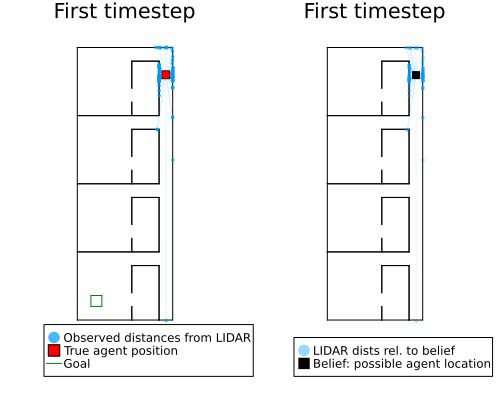

In [73]:
# Start the agent off in a hallway.
INITIAL_POS = [6.5, 4*5 - 2];
INITIAL_ROOM = square_rooms[1]; # Put the object in the bottom room

# Generate a rollout trace with just 1 timestep, constraining the random state
# to place the object and target object in the locations determined above.
rollout_tr = Gen.generate(rollout_model, (0, PARAMS), 
    choicemap(
        (GenPOMDPs.state_addr(0, :pos), INITIAL_POS),
        (GenPOMDPs.state_addr(0, :target_room), INITIAL_ROOM)
    )
)[1];

trace_to_gif(rollout_tr, title="First timestep")

In [74]:
rollout_tr, _ = Gen.update(rollout_tr,  # Update the record of the rollout...
    (180, PARAMS),                                        # ...updating it to a rollout of 100 steps, with the same PARAMS as before...
    (UnknownChange(), NoChange()),                        # ...noting that the time argument changed, and the params didn't
                                                          #    (so Gen knows not to revisit every choice depending on PARAMS)...
    EmptyChoiceMap()                                      # Don't constrain any of the randomness in the roll-out.
                                                          # (In principle, we could use this last argument to constrain either environmental
                                                          # randomness, or random choices made by the controller in the roll-out.)
);

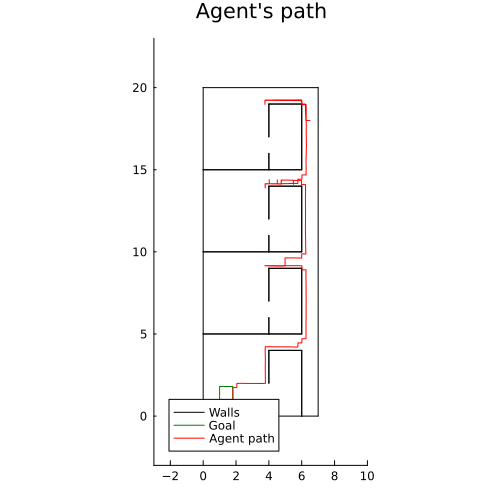

In [75]:
# Visualize the path the agent took.
trace_to_path_image(rollout_tr)

┌ Info: Saved animation to /tmp/jl_mxyfup4Pan.gif
└ @ Plots /home/ubuntu/.julia/packages/Plots/rz1WP/src/animation.jl:156


Plots.AnimatedGif("/tmp/jl_mxyfup4Pan.gif")
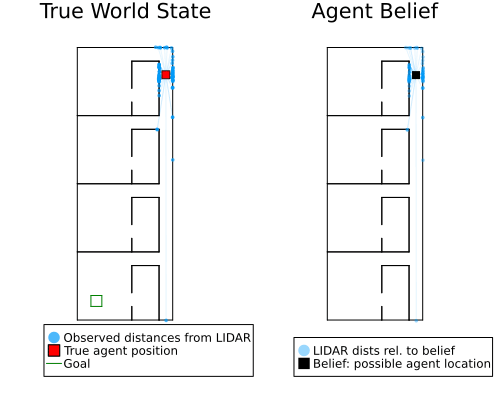

In [76]:
trace_to_gif(rollout_tr; fps=10)

Visualize when the agent is considering multiple hypotheses.  (That is, when its particle filter state resizes to 2 particles, when exploring rooms.)

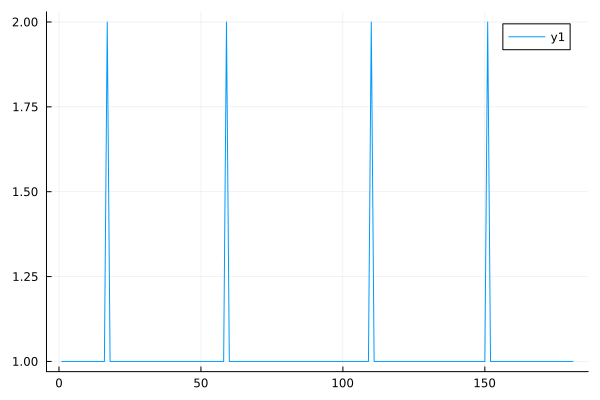

In [78]:
nparticles = [
    length(pf_state.traces) for (_, (pf_state, _, _)) in GenPOMDPs.control_sequence(rollout_tr)
]

plot(1:length(nparticles), nparticles)


## Possible next step: improve robustness of controller, so it can handle "kidnapped robot" problems

I can do a variant of the marginal likelihood estimate thresholding from the Kidnapped Robot demo.  Here, I will have to be a little more careful, so that the agent recognizes when there is ambiguity about its location (after a kidnapping), so it doesn't fill in its table of which rooms it has visited, and which it hasn't, incorrectly.